# Random Forest Classifier on the Titanic dataset


In [94]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [78]:
#import data
titanic_df = pd.read_csv("data/titanic_data.csv")

#some exploration:
print('Number of Rows: ', titanic_df.shape[0])
print('Number of Columns: ', titanic_df.shape[1], '\n')
print('Head of Data:\n ')
titanic_df.head()

Number of Rows:  891
Number of Columns:  12 

Head of Data:
 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can already drop some variables, such as passenger id, name, ticket, that should not be used as input because there is no logical connection between them and the chances of survival of the passenger. 

In [79]:
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'],axis=1)

Before starting to train a model, we need to make sure the data is clean. As we have done in Problem 3., let’s check for missing values.

In [80]:
print(f"Null Values in Dataset \n{titanic_df.isnull().sum()}")

Null Values in Dataset 
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


We can easily fill `embarked` with the most common port of embark.

In [81]:
print(f"Number of embarkations per port \n{titanic_df['Embarked'].value_counts()}")

#most common port is Southampton
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(value='S')

Number of embarkations per port 
S    644
C    168
Q     77
Name: Embarked, dtype: int64


Filling age is slightly more tricky. One common approach, discussed in depth in this [Kaggle article](https://www.kaggle.com/code/allohvk/titanic-missing-age-imputation-tutorial-advanced), is to fill every missing age with the average age for the title (Miss, Mr, Mrs, Master, Dr) of the passenger. Unfortunately, the `Title` variable is not included in our dataset. 

Random forests do not handle missing values in predictors; no clear solution can be found to impute the missing values, so I will have to drop the missing values at the risk of losing information, especially given the relatively small size of the sample. 

In [82]:
#drop NAs
titanic_df = titanic_df.dropna()

print(titanic_df.shape)


(714, 8)


Finally, we need to map categorical variables - Sex and Embarked - into numbers. This is easy to do in Pandas using map() method. 

In [83]:
categories = {"female": 1, "male": 0}
titanic_df['Sex']= titanic_df['Sex'].map(categories)

categories = {"S": 1, "C": 2, "Q": 3}
titanic_df['Embarked']= titanic_df['Embarked'].map(categories)

titanic_df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,1
1,1,1,1,38.0,1,0,71.2833,2
2,1,3,1,26.0,0,0,7.9250,1
3,1,1,1,35.0,1,0,53.1000,1
4,0,3,0,35.0,0,0,8.0500,1


Our data pre-processing is done! We can now split the Titanic data into train (with 70% of samples) and test (with 30% of samples) datasets.

In [84]:
# Separate the target variable & features
y_titanic = titanic_df.Survived
X_titanic = titanic_df.drop(['Survived'],axis=1)


# split the dataset into train and test
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=100)

Let's have a look at the shape of those new datasets

In [85]:
print("Shape of original dataset :", titanic_df.shape)
print("Shape of input - training set", X_train_titanic.shape)
print("Shape of output - training set", y_train_titanic.shape)
print("Shape of input - testing set", X_test_titanic.shape)
print("Shape of output - testing set", y_test_titanic.shape)

Shape of original dataset : (714, 8)
Shape of input - training set (499, 7)
Shape of output - training set (499,)
Shape of input - testing set (215, 7)
Shape of output - testing set (215,)


That looks good. We can now create a Random Forest with 100 trees, and train it on the train data.

In [86]:
#perform training with random forest with all columns
# specify random forest classifier
forest_clf = RandomForestClassifier(n_estimators=100)

# perform training
forest_clf.fit(X_train_titanic, y_train_titanic)

RandomForestClassifier()

Let's use this model to predict passenger survival in the testing dataset. 

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       137
           1       0.69      0.73      0.71        78

    accuracy                           0.78       215
   macro avg       0.76      0.77      0.77       215
weighted avg       0.78      0.78      0.78       215

Accuracy :  78.13953488372093


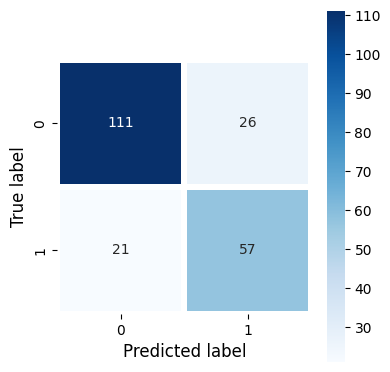

In [87]:
#prediction
y_pred_titanic = forest_clf.predict(X_test_titanic)

#classification report
print("Classification Report: ")
print(classification_report(y_test_titanic,y_pred_titanic))

#accuracy
print("Accuracy : ", accuracy_score(y_test_titanic, y_pred_titanic) * 100)

#confusion matrix
conf_matrix_titanic = confusion_matrix(y_test_titanic, y_pred_titanic)
conf_matrix_df_titanic = pd.DataFrame(conf_matrix_titanic, index=target_values, columns=target_values)

#plot
plt.figure(figsize=(4,4))
hm = sns.heatmap(conf_matrix_df_titanic, annot=True, fmt=".0f", linewidths=3, square=True, cmap='Blues', color="#cd1076")
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.tight_layout()
plt.show()


The model has moderate precision, recall, and F1-score for non-survivors (0.84, 0.81, and 0.83, respectively) and lower precision, recall, and F1-score for survivors (0.69, 0.73, and 0.71, respectively), indicating relatively accurate but not optimal classification performance. The model is better identifying dead people over survivors; this might be due to the fact that there are most examples of them. The overall accuracy of the model is 78.1%, indicating that it correctly predicted the class labels for 78.1% of the instances in the testing sample. 


### Importance of the features

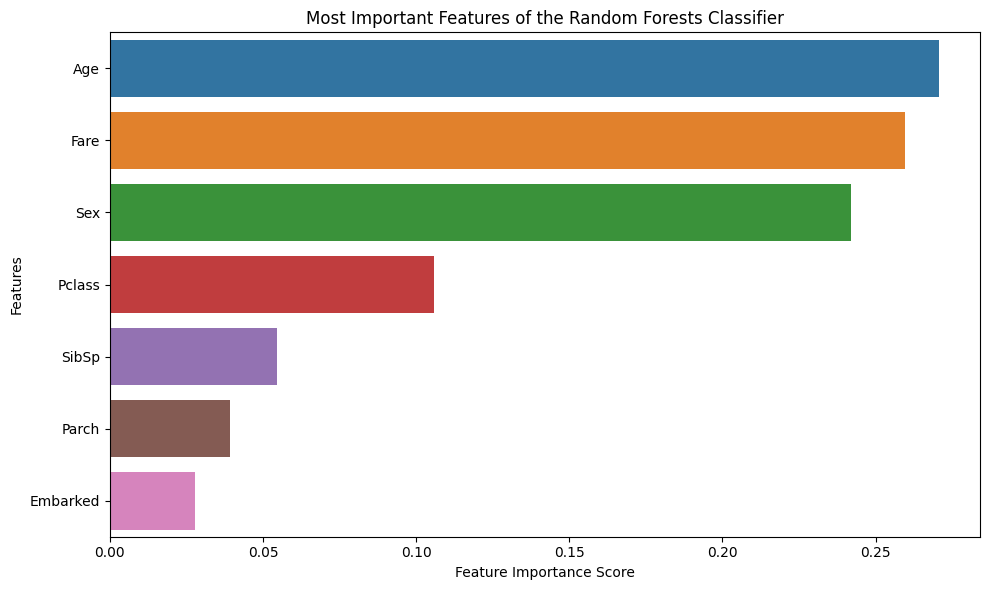

In [88]:
#get Series of feature importances
feat_imp = pd.Series(forest_clf.feature_importances_, index=X_train_titanic.columns).sort_values(ascending=False)

#bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Most Important Features of the Random Forests Classifier")
plt.tight_layout()